In [1]:
from datetime import datetime
# globalstart = datetime.now()
import pandas as pd
import numpy as np
import matplotlib
matplotlib.use('nbagg')

import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})

import seaborn as sns
sns.set_style('whitegrid')
import os
from scipy import sparse
from scipy.sparse import csr_matrix

from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
import random

import warnings
warnings.filterwarnings('ignore')

In [ ]:
start = datetime.now()
filename = 'data.csv'
filedir = '/content/drive/MyDrive/Recommendation System_Case Study/'
files = os.listdir(filedir)
if filename not in files:
    # Create a file 'data.csv' before reading it
    # Read all the files in netflix and store them in one big file('data.csv')
    # We re reading from each of the four files and appendig each rating to a global file 'train.csv'
    data = open(filedir + filename, mode='w')
    featurelist = ['movie','user','rating','date']
    data.write(','.join(featurelist))
    data.write('\n')
    
    row = list()
    file = '/content/drive/MyDrive/Recommendation System_Case Study/combined_data_1.txt'
    print("Reading ratings from {}...".format(file))
    with open(file) as f:
        for line in f:
            line = line.strip()
            if line.endswith(':'):
                # All below are ratings for this movie, until another movie appears.
                movie_id = line.replace(':', '')
            else:
                row = [x for x in line.split(',')]
                row.insert(0, movie_id)
                data.write(','.join(row))
                data.write('\n')
    print("Done.\n")
    data.close()
print('Time taken :', datetime.now() - start)

Reading ratings from /content/drive/MyDrive/Recommendation System_Case Study/combined_data_1.txt...
Done.

Time taken : 0:00:50.479680


In [2]:
print("creating the dataframe from data.csv file..")
df = pd.read_csv('/content/drive/MyDrive/Recommendation System_Case Study/data.csv', sep=',')
df.date = pd.to_datetime(df.date)
print('Done.\n')

# we are arranging the ratings according to time.
print('Sorting the dataframe by Date..')
df.sort_values(by='date', inplace=True)
print('Done..')

creating the dataframe from data.csv file..
Done.

Sorting the dataframe by Date..
Done..


In [48]:
df.head()

,movie,user,rating,date
9056171,1798,510180,5,1999-11-11
14892677,2866,510180,3,1999-11-11
19585852,3730,510180,4,1999-11-11
20393918,3870,510180,2,1999-11-11
6901473,1367,510180,5,1999-11-11


In [4]:
df.describe()

,movie,user,rating
count,2.405376e+07,2.405376e+07,2.405376e+07
mean,2.308324e+03,1.322285e+06,3.599634e+00
std,1.303909e+03,7.645779e+05,1.086118e+00
min,1.000000e+00,6.000000e+00,1.000000e+00
25%,1.180000e+03,6.609270e+05,3.000000e+00
50%,2.342000e+03,1.318602e+06,4.000000e+00
75%,3.433000e+03,1.984358e+06,4.000000e+00
max,4.499000e+03,2.649429e+06,5.000000e+00


In [5]:
# just to make sure that all Nan containing rows are deleted..
print("No of Nan values in our dataframe : ", sum(df.isnull().any()))

No of Nan values in our dataframe :  0


In [6]:
dup_bool = df.duplicated(['movie','user','rating'])
dups = sum(dup_bool) # by considering all columns..( including timestamp)
print("There are {} duplicate rating entries in the data..".format(dups))

There are 0 duplicate rating entries in the data..


In [7]:
print("Total data ")
print("-"*50)
print("\nTotal no of ratings :",df.shape[0])
print("Total No of Users   :", len(np.unique(df.user)))
print("Total No of movies  :", len(np.unique(df.movie)))

Total data 
--------------------------------------------------

Total no of ratings : 24053764
Total No of Users   : 470758
Total No of movies  : 4499


In [8]:
filedir = '/content/drive/MyDrive/Recommendation System_Case Study/'
files = os.listdir(filedir)
trainfilename = 'train.csv'
testfilename = 'test.csv'
if trainfilename not in files:
    # create the dataframe and store it in the disk for offline purposes..
    df.iloc[:int(df.shape[0]*0.80)].to_csv(filedir + trainfilename, index=False)

if testfilename not in files:
    # create the dataframe and store it in the disk for offline purposes..
    df.iloc[int(df.shape[0]*0.80):].to_csv(filedir + testfilename, index=False)

In [9]:
filedir = '/content/drive/MyDrive/Recommendation System_Case Study/'
trainfilename = 'train.csv'
testfilename = 'test.csv'
train_df = pd.read_csv(filedir + trainfilename, parse_dates=['date'])
test_df = pd.read_csv(filedir + testfilename)

In [10]:
# movies = train_df.movie.value_counts()
# users = train_df.user.value_counts()
print("Training data ")
print("-"*50)
print("\nTotal no of ratings :",train_df.shape[0])
print("Total No of Users   :", len(np.unique(train_df.user)))
print("Total No of movies  :", len(np.unique(train_df.movie)))

Training data 
--------------------------------------------------

Total no of ratings : 2425000
Total No of Users   : 83910
Total No of movies  : 2634


In [11]:
print("Test data ")
print("-"*50)
print("\nTotal no of ratings :",test_df.shape[0])
print("Total No of Users   :", len(np.unique(test_df.user)))
print("Total No of movies  :", len(np.unique(test_df.movie)))

Test data 
--------------------------------------------------

Total no of ratings : 4810753
Total No of Users   : 302727
Total No of movies  : 4497


#**Exploratory Data Analysis**

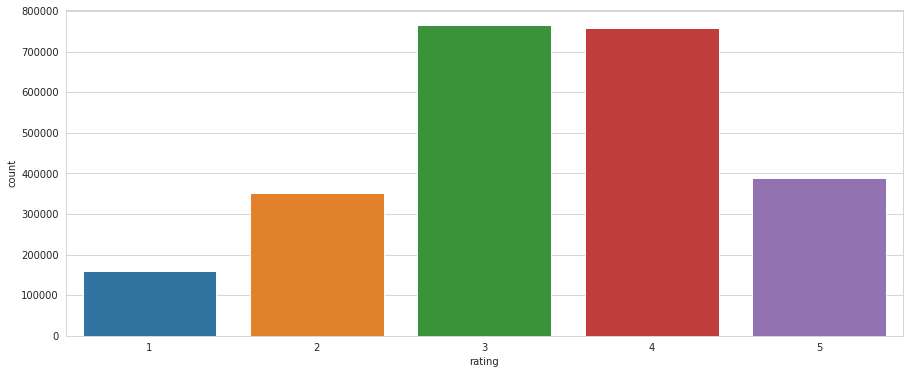

In [ ]:
plt.figure(figsize = (15,6))
sns.countplot(x= train_df.rating)
plt.show()

In [ ]:
plt.figure(figsize = (15,6))
sns.countplot(x= train_df.rating)
plt.show()

**Add new column (week day) to the data set for analysis.**

In [12]:
train_df.iloc[0].date,train_df.iloc[0].date.weekday()

(Timestamp('1999-11-11 00:00:00'), 3)

In [13]:
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
train_df['day_of_week'] = train_df.date.dt.weekday.apply(lambda x: days[x])

train_df.tail()

,movie,user,rating,date,day_of_week
2424995,2254,1910590,3,2003-07-08,Tuesday
2424996,1615,781778,4,2003-07-08,Tuesday
2424997,4227,1850072,3,2003-07-08,Tuesday
2424998,482,330278,4,2003-07-08,Tuesday
2424999,3368,904391,2,2003-07-08,Tuesday


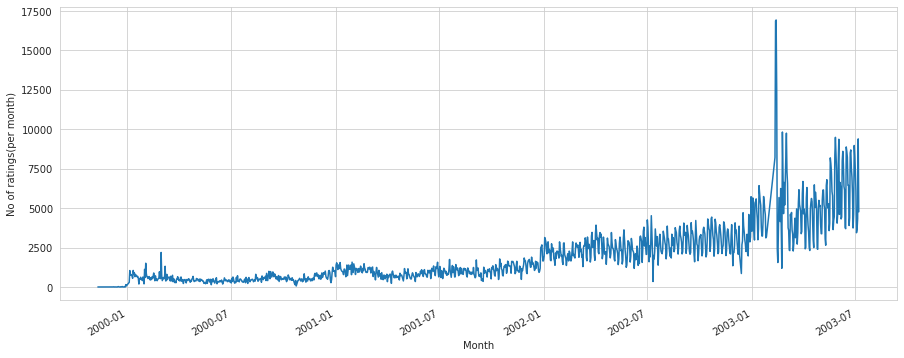

In [14]:
plt.figure(figsize = (15,6))
train_df.groupby(by = 'date').rating.count().plot()
plt.xlabel('Month')
plt.ylabel('No of ratings(per month)')
plt.show()

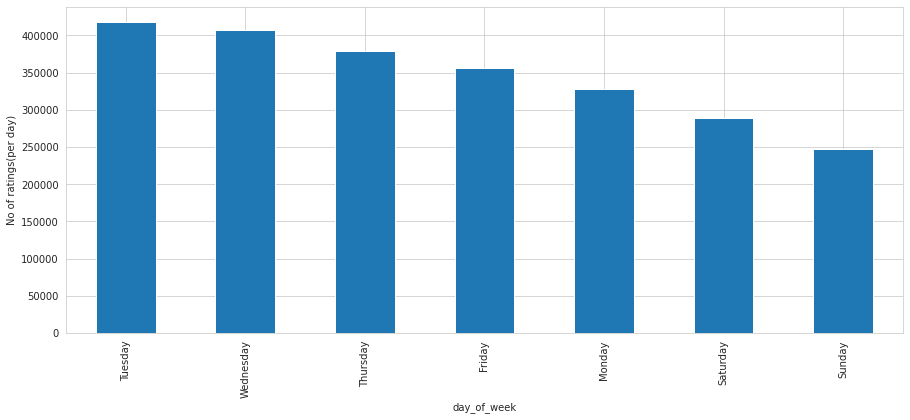

In [15]:
plt.figure(figsize = (15,6))
train_df.groupby(by = 'day_of_week').rating.count().sort_values(ascending = False).plot(kind = 'bar')
plt.xlabel('day_of_week')
plt.ylabel('No of ratings(per day)')
plt.show()

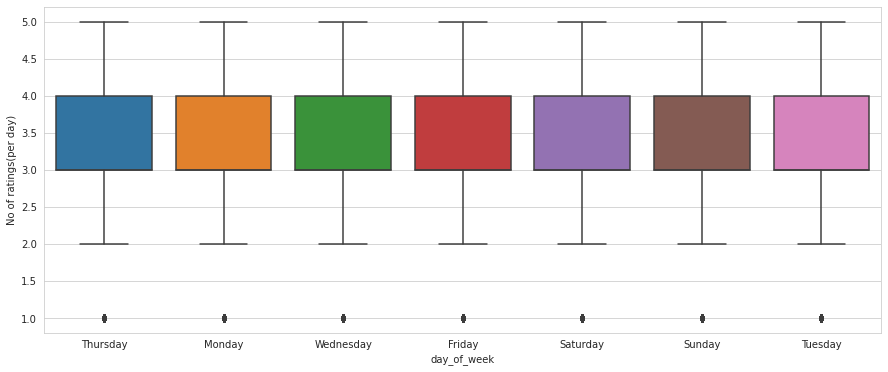

In [16]:
plt.figure(figsize = (15,6))
sns.boxplot(data = train_df, x = 'day_of_week', y = 'rating')
plt.xlabel('day_of_week')
plt.ylabel('No of ratings(per day)')
plt.show()

In [17]:
train_df.groupby(by = 'day_of_week').rating.mean()

day_of_week
Friday       3.360033
Monday       3.351430
Saturday     3.352163
Sunday       3.351249
Thursday     3.361011
Tuesday      3.354272
Wednesday    3.359055
Name: rating, dtype: float64

Days of week can't be a good feature to predict Rating.

**Analyse the rating w.r.t per user**

In [18]:
no_of_rated_movies_per_user = train_df.groupby(by = 'user').rating.count().sort_values(ascending = False)
no_of_rated_movies_per_user.head()

user
2439493    2229
1639792    2170
305344     1710
798296     1436
752642     1313
Name: rating, dtype: int64

In [19]:
no_of_rated_movies_per_user.shape

(83910,)

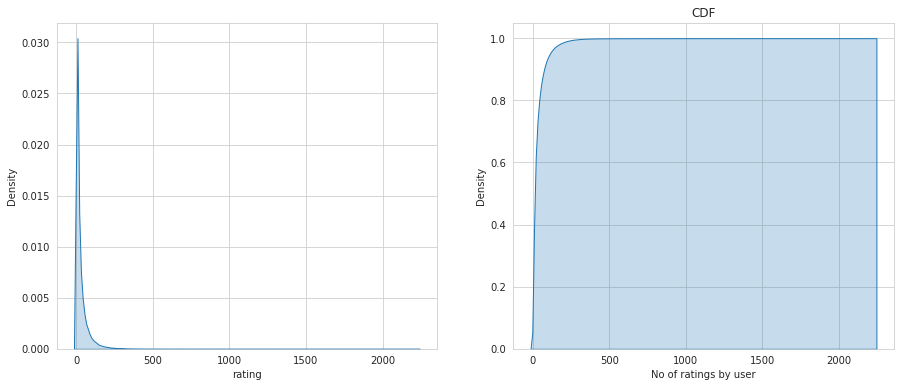

In [20]:
fig,axes = plt.subplots(nrows= 1,ncols = 2,figsize= (15,6))
sns.kdeplot(no_of_rated_movies_per_user, shade=True, ax=axes[0])
plt.xlabel('No of ratings by user')
plt.title("PDF")

sns.kdeplot(no_of_rated_movies_per_user, shade=True, cumulative=True,ax=axes[1])
plt.xlabel('No of ratings by user')
plt.title('CDF')

plt.show()

In [21]:
no_of_rated_movies_per_user.describe()

count    83910.000000
mean        28.900012
std         47.354202
min          1.000000
25%          4.000000
50%         12.000000
75%         34.000000
max       2229.000000
Name: rating, dtype: float64

In [22]:
for perc in range(75,105,5):
  val = np.percentile(np.array(no_of_rated_movies_per_user.values),perc)
  print('{}th percentile is: {}'.format(perc,val))

75th percentile is: 34.0
80th percentile is: 43.0
85th percentile is: 55.0
90th percentile is: 74.0
95th percentile is: 112.0
100th percentile is: 2229.0


In [23]:
for perc in range(95,101,1):
  val = np.percentile(np.array(no_of_rated_movies_per_user.values),perc)
  print('{}th percentile is: {}'.format(perc,val))

95th percentile is: 112.0
96th percentile is: 125.0
97th percentile is: 143.0
98th percentile is: 171.0
99th percentile is: 218.9100000000035
100th percentile is: 2229.0


In [24]:
perc_range = list(np.arange(99.90,100.01,.01).round(2))
for perc in perc_range:
  val = np.percentile(np.array(no_of_rated_movies_per_user.values),perc)
  print('{}th percentile is: {}'.format(perc,val))

99.9th percentile is: 399.0910000000149
99.91th percentile is: 405.9637999999977
99.92th percentile is: 418.87279999999737
99.93th percentile is: 436.52740000002086
99.94th percentile is: 459.61839999997756
99.95th percentile is: 482.0910000000149
99.96th percentile is: 527.7455999999656
99.97th percentile is: 570.6546000000089
99.98th percentile is: 681.8728000000119
99.99th percentile is: 950.7000999998563
100.0th percentile is: 2229.0


In [25]:
perc = no_of_rated_movies_per_user[no_of_rated_movies_per_user.values > np.percentile(np.array(no_of_rated_movies_per_user.values),99.99)]\
      .shape[0]/no_of_rated_movies_per_user.shape[0]

print('{}% of people rated movies more than 950.'.format(perc))

0.00010725777618877369% of people rated movies more than 950.


**Analysis of ratings of a movie given by a user**

In [26]:
no_of_rated_movies_per_movie = train_df.groupby(by = 'movie').rating.count().sort_values(ascending = False)
no_of_rated_movies_per_movie.head()

movie
571     35290
985     26261
4306    25553
708     24878
3106    24334
Name: rating, dtype: int64

In [27]:
no_of_rated_movies_per_movie.describe()

count     2634.000000
mean       920.652999
std       2588.135932
min          1.000000
25%         40.250000
50%        109.000000
75%        489.750000
max      35290.000000
Name: rating, dtype: float64

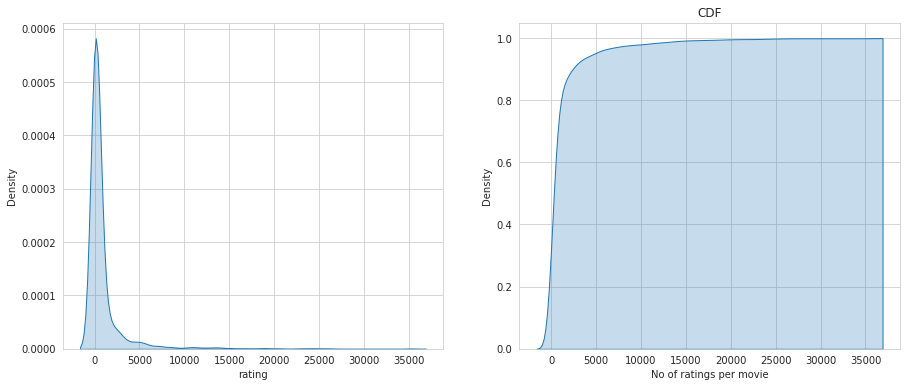

In [28]:
fig,axes = plt.subplots(nrows= 1,ncols = 2,figsize= (15,6))
sns.kdeplot(no_of_rated_movies_per_movie, shade=True, ax=axes[0])
plt.xlabel('No of ratings per movie')
plt.title("PDF")

sns.kdeplot(no_of_rated_movies_per_movie, shade=True, cumulative=True,ax=axes[1])
plt.xlabel('No of ratings per movie')
plt.title('CDF')

plt.show()

Creating Sparse Matrix for Train and Test Data

In [29]:
start = datetime.now()
filedir = '/content/drive/MyDrive/Recommendation System_Case Study/'
files = os.listdir(filedir)
filename = 'train_sparse_matrix.npz'
if filename in files:
    print("It is present in your pwd, getting it from disk....")
    # just get it from the disk instead of computing it
    train_sparse_matrix = sparse.load_npz(filedir + filename)
    print("DONE..")
else: 
    print("We are creating sparse_matrix from the dataframe..")
    # create sparse_matrix and store it for after usage.
    # csr_matrix(data_values, (row_index, col_index), shape_of_matrix) -- VVIMP
    # It should be in such a way that, MATRIX[row, col] = data
    train_sparse_matrix = sparse.csr_matrix((train_df.rating.values, (train_df.user.values,
                                               train_df.movie.values)),)
    
    print('Done. It\'s shape is : (user, movie) : ',train_sparse_matrix.shape)
    print('Saving it into disk for furthur usage..')
    # save it into disk
    sparse.save_npz(filedir + filename, train_sparse_matrix)
    print('Done..\n')

print(datetime.now() - start)

It is present in your pwd, getting it from disk....
DONE..
0:00:00.457537


In [30]:
us,mv = train_sparse_matrix.shape
elem = train_sparse_matrix.count_nonzero()

print("Sparsity Of Train matrix : {} % ".format(  (1-(elem/(us*mv))) * 100) )

Sparsity Of Train matrix : 99.97965567429247 % 


In [31]:
start = datetime.now()
filedir = '/content/drive/MyDrive/Recommendation System_Case Study/'
files = os.listdir(filedir)
filename = 'test_sparse_matrix.npz'
if filename in files:
    print("It is present in your pwd, getting it from disk....")
    # just get it from the disk instead of computing it
    test_sparse_matrix = sparse.load_npz(filedir + filename)
    print("DONE..")
else: 
    print("We are creating sparse_matrix from the dataframe..")
    # create sparse_matrix and store it for after usage.
    # csr_matrix(data_values, (row_index, col_index), shape_of_matrix)
    # It should be in such a way that, MATRIX[row, col] = data
    test_sparse_matrix = sparse.csr_matrix((test_df.rating.values, (test_df.user.values,
                                               test_df.movie.values)),)
    
    print('Done. It\'s shape is : (user, movie) : ',test_sparse_matrix.shape)
    print('Saving it into disk for furthur usage..')
    # save it into disk
    sparse.save_npz(filedir + filename, test_sparse_matrix)
    print('Done..\n')

print(datetime.now() - start)

It is present in your pwd, getting it from disk....
DONE..
0:00:00.988170


In [32]:
us,mv = test_sparse_matrix.shape
elem = test_sparse_matrix.count_nonzero()

print("Sparsity Of Test matrix : {} % ".format(  (1-(elem/(us*mv))) * 100) )

Sparsity Of Test matrix : 99.95964957661752 % 


Finding Global average of all movie ratings, Average rating per user, and Average rating per movie

In [33]:
train_averages = dict()
train_global_avg = train_df.rating.mean()
train_averages['global'] = train_global_avg
train_averages

{'global': 3.356036288659794}

In [34]:
train_averages_per_user = pd.DataFrame(train_df.groupby(by = 'user').rating.mean())
train_averages_per_user.reset_index(inplace = True)
train_averages_per_user.rename(columns = {'index':'user','user':'Mean Rating per user'})
train_averages_per_user.head()

,user,rating
0,10,3.357143
1,79,3.240000
2,83,4.250000
3,192,3.166667
4,201,3.565217


In [35]:
train_averages_per_user.shape

(83910, 2)

In [36]:
train_averages_per_movie = pd.DataFrame(train_df.groupby(by = 'movie').rating.mean())
train_averages_per_movie.reset_index(inplace = True)
train_averages_per_movie.rename(columns = {'index':'movie','movie':'Mean Rating per movie'})
train_averages_per_movie.head()

,movie,rating
0,3,3.541667
1,7,1.857143
2,10,3.025641
3,11,2.166667
4,12,3.000000


In [37]:
train_averages_per_movie.shape

(2634, 2)

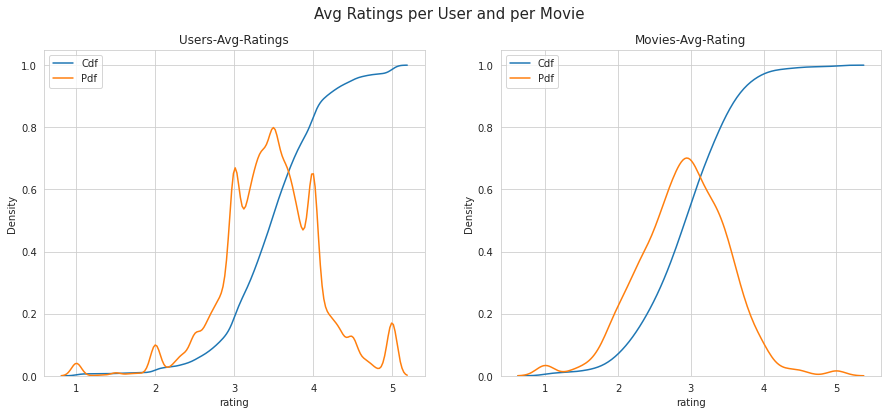

0:00:02.653981


In [38]:
start = datetime.now()
# draw pdfs for average rating per user and average
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
fig.suptitle('Avg Ratings per User and per Movie', fontsize=15)

ax1.set_title('Users-Avg-Ratings')
# get the list of average user ratings from the averages dictionary..
sns.distplot(train_averages_per_user.rating, ax=ax1, hist=False, 
             kde_kws=dict(cumulative=True), label='Cdf')
sns.distplot(train_averages_per_user.rating, ax=ax1, hist=False,label='Pdf')
ax1.legend()

ax2.set_title('Movies-Avg-Rating')
# get the list of movie_average_ratings from the dictionary..
sns.distplot(train_averages_per_movie.rating, ax=ax2, hist=False, 
             kde_kws=dict(cumulative=True), label='Cdf')
sns.distplot(train_averages_per_movie.rating, ax=ax2, hist=False, label='Pdf')
ax2.legend()

plt.show()
print(datetime.now() - start)

**Cold Start problem with Users**

In [39]:
total_users = len(np.unique(df.user))
users_train = len(train_averages_per_user['user'])
new_users = total_users - users_train

print('\nTotal number of Users  :', total_users)
print('\nNumber of Users in Train data :', users_train)
print("\nNo of Users that didn't appear in train data: {}({} %) \n ".format(new_users,
                                                                        np.round((new_users/total_users)*100, 2)))


Total number of Users  : 470758

Number of Users in Train data : 83910

No of Users that didn't appear in train data: 386848(82.18 %) 
 


**Cold Start problem with Movies**

In [40]:
total_movies = len(np.unique(df.movie))
movies_train = len(train_averages_per_movie['movie'])
new_movies = total_movies - movies_train

print('\nTotal number of Movies  :', total_movies)
print('\nNumber of Movies in Train data :', movies_train)
print("\nNo of Movies that didn't appear in train data: {}({} %) \n ".format(new_movies,
                                                                        np.round((new_movies/total_movies)*100, 2)))


Total number of Movies  : 4499

Number of Movies in Train data : 2634

No of Movies that didn't appear in train data: 1865(41.45 %) 
 


**Computing Similarity matrices**

Computing User-User Similarity matrix

In [ ]:
train_sparse_matrix.shape

(2649430, 4499)

In [ ]:
start = datetime.now()
u_u_sim_sparse = cosine_similarity(X=train_sparse_matrix, dense_output=False)
print(u_u_sim_sparse.shape)
print('time taken:{}'.format(datetime.now()-start))

User-User Similarity failed tocompute because of lack of high compute resource.

Computing Movie-Movie Similarity matrix

In [41]:
start = datetime.now()
filedir = '/content/drive/MyDrive/Recommendation System_Case Study/'
files = os.listdir(filedir)
filename = 'm_m_sim_sparse.npz'
if filename not in files:
    print("It seems you don't have that file. Computing movie_movie similarity...")
    start = datetime.now()
    m_m_sim_sparse = cosine_similarity(X=train_sparse_matrix.T, dense_output=False)
    print("Done..")
    # store this sparse matrix in disk before using it. For future purposes.
    print("Saving it to disk without the need of re-computing it again.. ")
    sparse.save_npz(filedir + filename, m_m_sim_sparse)
    print("Done..")
else:
    print("It is there, We will get it.")
    m_m_sim_sparse = sparse.load_npz(filedir + filename)
    print("Done ...")

print("It's a ",m_m_sim_sparse.shape," dimensional matrix")

print(datetime.now() - start)

It is there, We will get it.
Done ...
It's a  (4499, 4499)  dimensional matrix
0:00:01.325019


Even though we have similarity measure of each movie, with all other movies, We generally don't care much about least similar movies.
Most of the times, only top_xxx similar items matters. It may be 10 or 100.
We take only those top similar movie ratings and store them in a saperate dictionary.

In [42]:
movie_ids = np.unique(m_m_sim_sparse.nonzero()[0])

In [43]:
start = datetime.now()
similar_movies = dict()
for movie in movie_ids:
    # get the top similar movies and store them in the dictionary
    sim_movies = m_m_sim_sparse[movie].toarray().ravel().argsort()[::-1][1:]
    similar_movies[movie] = sim_movies[:100]
print(datetime.now() - start)

# just testing similar movies for movie_15
similar_movies[15]

0:00:01.026684


array([4206, 3602, 1720, 1696, 1903, 1386, 1690, 1071, 2555, 3839,  945,
        772, 2914, 2245, 2261, 3891, 4404,  203, 4125, 1410, 2923, 1520,
       4186, 3644, 3400, 4223,  147, 4025, 3008,  830, 1847,  735, 1942,
       4462, 1391, 4464, 2624, 3158, 3619, 4236, 4424, 2973, 3973,  196,
       3856,  214, 2703, 2835,  598, 3964, 1493,  610, 3206,  612, 1651,
       1968, 1496, 1056, 3392,  888, 3884,  593, 3661, 2231,  714, 4088,
       1079,  800, 2253, 1166, 2210, 4076, 4318, 1517, 2728, 3511, 3027,
       3653,  525,  380, 3580, 1322, 3786, 2415, 2065, 2347, 2886,   87,
       2307,  328, 3501, 2545, 1030, 3356, 4246, 1284, 2373, 2219, 2361,
       2107])

To test on the similar Movies

In [44]:
filepath = '/content/drive/MyDrive/Recommendation System_Case Study/movie_titles.csv'
movie_title = pd.read_csv(filepath,sep=',', header = None,
                           names=['movie_id', 'year_of_release', 'title'], verbose=True,
                      index_col = 'movie_id',encoding = "ISO-8859-1")
movie_title.head()

Tokenization took: 3.74 ms
Type conversion took: 8.07 ms
Parser memory cleanup took: 0.01 ms


,year_of_release,title
movie_id,,
1,2003.0,Dinosaur Planet
2,2004.0,Isle of Man TT 2004 Review
3,1997.0,Character
4,1994.0,Paula Abdul's Get Up & Dance
5,2004.0,The Rise and Fall of ECW


In [45]:
movie_title.loc[67]

year_of_release              1997.0
title              Vampire Journals
Name: 67, dtype: object

In [46]:
similar_movies[67]

array([1657,  323, 4052, 2269, 2667, 1900, 1342, 1688,  308,  146, 2708,
       1807,  408, 2948, 4336, 4218, 4126,  190, 2563, 2029, 1154, 4197,
       2004, 1334,  427, 3496, 3311, 1187, 2060, 1143, 2127, 4044, 3043,
       1282, 4420,  572, 3049,  134, 2633, 2318,  587,  821, 3343, 4085,
        674,  986, 2516, 3268, 2887, 1410,  740, 2718, 1083, 4310, 3644,
       2037, 4386, 3212, 3261, 2047, 1333, 4421, 2263, 1369, 1950, 3602,
       3768, 4170, 4097, 2394,  605, 2415,  819, 3248,   48, 3097, 2508,
       1633,  527, 1864,  461, 1833, 2266, 1808, 2132,  859, 2252, 2286,
       2900, 1343, 2600,  479, 2046, 1438, 1566, 2201, 2853, 1003, 4112,
       1634])

In [47]:
movie_title.loc[similar_movies[67][:10]]

,year_of_release,title
movie_id,,
1657,1995.0,Forbidden Games
323,1999.0,Modern Vampires
4052,2001.0,All the Queen's Men
2269,2003.0,People I Know
2667,1971.0,Devil's Nightmare
1900,1997.0,Club Vampire
1342,2003.0,Bog Creatures
1688,1993.0,To Sleep With a Vampire
308,1974.0,The Legend of the 7 Golden Vampires/7 Brothers...


**Machine Learning Models**

Sample Data Creation

In [50]:
def get_sample_sparse_matrix(sparse_matrix, no_users, no_movies, path, verbose = True):
    """
        It will get it from the ''path'' if it is present  or It will create 
        and store the sampled sparse matrix in the path specified.
    """

    # get (row, col) and (rating) tuple from sparse_matrix...
    row_ind, col_ind, ratings = sparse.find(sparse_matrix)
    users = np.unique(row_ind)
    movies = np.unique(col_ind)

    print("Original Matrix : (users, movies) -- ({} {})".format(len(users), len(movies)))
    print("Original Matrix : Ratings -- {}\n".format(len(ratings)))

    # It just to make sure to get same sample everytime we run this program..
    # and pick without replacement....
    np.random.seed(15)
    sample_users = np.random.choice(users, no_users, replace=False)
    sample_movies = np.random.choice(movies, no_movies, replace=False)
    # get the boolean mask or these sampled_items in originl row/col_inds..
    mask = np.logical_and( np.isin(row_ind, sample_users),
                      np.isin(col_ind, sample_movies) )
    
    sample_sparse_matrix = sparse.csr_matrix((ratings[mask], (row_ind[mask], col_ind[mask])),
                                             shape=(max(sample_users)+1, max(sample_movies)+1))

    if verbose:
        print("Sampled Matrix : (users, movies) -- ({} {})".format(len(sample_users), len(sample_movies)))
        print("Sampled Matrix : Ratings --", format(ratings[mask].shape[0]))

    print('Saving it into disk for furthur usage..')
    # save it into disk
    sparse.save_npz(path, sample_sparse_matrix)
    if verbose:
            print('Done..\n')
    
    return sample_sparse_matrix

In [51]:
start = datetime.now()
filedir = '/content/drive/MyDrive/Recommendation System_Case Study/'
files = os.listdir(filedir)
filename = 'sample_train_sparse_matrix.npz'
if filename in files:
    print("It is present in your pwd, getting it from disk....")
    # just get it from the disk instead of computing it
    sample_train_sparse_matrix = sparse.load_npz(filedir + filename)
    print("DONE..")
else: 
    # get 10k users and 1k movies from available data 
    sample_train_sparse_matrix = get_sample_sparse_matrix(train_sparse_matrix, no_users=10000, no_movies=1000,
                                             path = filedir + filename)

print(datetime.now() - start)

Original Matrix : (users, movies) -- (83910 2634)
Original Matrix : Ratings -- 2425000

Sampled Matrix : (users, movies) -- (10000 1000)
Sampled Matrix : Ratings -- 104222
Saving it into disk for furthur usage..
Done..

0:00:01.210632


In [52]:
start = datetime.now()
filedir = '/content/drive/MyDrive/Recommendation System_Case Study/'
files = os.listdir(filedir)
filename = 'sample_test_sparse_matrix.npz'
if filename in files:
    print("It is present in your pwd, getting it from disk....")
    # just get it from the disk instead of computing it
    sample_test_sparse_matrix = sparse.load_npz(filedir + filename)
    print("DONE..")
else:
    # get 5k users and 500 movies from available data 
    sample_test_sparse_matrix = get_sample_sparse_matrix(test_sparse_matrix, no_users=5000, no_movies=500,
                                                 path = filedir + filename)
print(datetime.now() - start)

Original Matrix : (users, movies) -- (302727 4497)
Original Matrix : Ratings -- 4810753

Sampled Matrix : (users, movies) -- (5000 500)
Sampled Matrix : Ratings -- 10988
Saving it into disk for furthur usage..
Done..

0:00:02.315856


Finding Global Average of all movie ratings

In [53]:
sample_train_averages = dict()
sample_global_average = sample_train_sparse_matrix.sum()/sample_train_sparse_matrix.shape[0]
sample_train_averages['global'] = sample_global_average
sample_train_averages

{'global': 0.1318408054094575}

In [54]:
def get_average_ratings(sparse_matrix, of_users):
    
    # average ratings of user/axes
    ax = 1 if of_users else 0 # 1 - User axes,0 - Movie axes

    # ".A1" is for converting Column_Matrix to 1-D numpy array 
    sum_of_ratings = sparse_matrix.sum(axis=ax).A1
    # Boolean matrix of ratings ( whether a user rated that movie or not)
    is_rated = sparse_matrix!=0
    # no of ratings that each user OR movie..
    no_of_ratings = is_rated.sum(axis=ax).A1
    
    # max_user  and max_movie ids in sparse matrix 
    u,m = sparse_matrix.shape
    # creae a dictonary of users and their average ratigns..
    average_ratings = { i : sum_of_ratings[i]/no_of_ratings[i]
                                 for i in range(u if of_users else m) 
                                    if no_of_ratings[i] !=0}

    # return that dictionary of average ratings
    return average_ratings

In [55]:
sample_train_averages['user'] = get_average_ratings(sample_train_sparse_matrix, of_users=True)

In [56]:
sample_train_averages['movie'] = get_average_ratings(sample_train_sparse_matrix, of_users=False)

**Featurizing data for regression problem**

Featurizing train data

In [57]:
# get users, movies and ratings from our samples train sparse matrix
sample_train_users, sample_train_movies, sample_train_ratings = sparse.find(sample_train_sparse_matrix)

In [ ]:
############################################################
# It took me almost 10 hours to prepare this train dataset.#
############################################################
start = datetime.now()
if os.path.isfile('sample/small/reg_train.csv'):
    print("File already exists you don't have to prepare again..." )
else:
    print('preparing {} tuples for the dataset..\n'.format(len(sample_train_ratings)))
    with open('sample/small/reg_train.csv', mode='w') as reg_data_file:
        count = 0
        for (user, movie, rating)  in zip(sample_train_users, sample_train_movies, sample_train_ratings):
            st = datetime.now()
        #     print(user, movie)    
            #--------------------- Ratings of "movie" by similar users of "user" ---------------------
            # compute the similar Users of the "user"        
            user_sim = cosine_similarity(sample_train_sparse_matrix[user], sample_train_sparse_matrix).ravel()
            top_sim_users = user_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
            # get the ratings of most similar users for this movie
            top_ratings = sample_train_sparse_matrix[top_sim_users, movie].toarray().ravel()
            # we will make it's length "5" by adding movie averages to .
            top_sim_users_ratings = list(top_ratings[top_ratings != 0][:5])
            top_sim_users_ratings.extend([sample_train_averages['movie'][movie]]*(5 - len(top_sim_users_ratings)))
        #     print(top_sim_users_ratings, end=" ")    


            #--------------------- Ratings by "user"  to similar movies of "movie" ---------------------
            # compute the similar movies of the "movie"        
            movie_sim = cosine_similarity(sample_train_sparse_matrix[:,movie].T, sample_train_sparse_matrix.T).ravel()
            top_sim_movies = movie_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
            # get the ratings of most similar movie rated by this user..
            top_ratings = sample_train_sparse_matrix[user, top_sim_movies].toarray().ravel()
            # we will make it's length "5" by adding user averages to.
            top_sim_movies_ratings = list(top_ratings[top_ratings != 0][:5])
            top_sim_movies_ratings.extend([sample_train_averages['user'][user]]*(5-len(top_sim_movies_ratings))) 
        #     print(top_sim_movies_ratings, end=" : -- ")

            #-----------------prepare the row to be stores in a file-----------------#
            row = list()
            row.append(user)
            row.append(movie)
            # Now add the other features to this data...
            row.append(sample_train_averages['global']) # first feature
            # next 5 features are similar_users "movie" ratings
            row.extend(top_sim_users_ratings)
            # next 5 features are "user" ratings for similar_movies
            row.extend(top_sim_movies_ratings)
            # Avg_user rating
            row.append(sample_train_averages['user'][user])
            # Avg_movie rating
            row.append(sample_train_averages['movie'][movie])

            # finalley, The actual Rating of this user-movie pair...
            row.append(rating)
            count = count + 1

            # add rows to the file opened..
            reg_data_file.write(','.join(map(str, row)))
            reg_data_file.write('\n')        
            if (count)%10000 == 0:
                # print(','.join(map(str, row)))
                print("Done for {} rows----- {}".format(count, datetime.now() - start))


print(datetime.now() - start)

preparing 129286 tuples for the dataset..

Done for 10000 rows----- 0:53:13.974716
Done for 20000 rows----- 1:47:58.228942
Done for 30000 rows----- 2:42:46.963119
Done for 40000 rows----- 3:36:44.807894
Done for 50000 rows----- 4:28:55.311500
Done for 60000 rows----- 5:24:18.493104
Done for 70000 rows----- 6:17:39.669922
Done for 80000 rows----- 7:11:23.970879
Done for 90000 rows----- 8:05:33.787770
Done for 100000 rows----- 9:00:25.463562
Done for 110000 rows----- 9:51:28.530010
Done for 120000 rows----- 10:42:05.382141
11:30:13.699183


In [ ]:
reg_train = pd.read_csv('sample/small/reg_train.csv', names = ['user', 'movie', 'GAvg', 'sur1', 'sur2', 'sur3', 'sur4', 'sur5','smr1', 'smr2', 'smr3', 'smr4', 'smr5', 'UAvg', 'MAvg', 'rating'], header=None)
reg_train.head()

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating
0,53406,33,3.581679,4.0,5.0,5.0,4.0,1.0,5.0,2.0,5.0,3.0,1.0,3.370370,4.092437,4
1,99540,33,3.581679,5.0,5.0,5.0,4.0,5.0,3.0,4.0,4.0,3.0,5.0,3.555556,4.092437,3
2,99865,33,3.581679,5.0,5.0,4.0,5.0,3.0,5.0,4.0,4.0,5.0,4.0,3.714286,4.092437,5
3,101620,33,3.581679,2.0,3.0,5.0,5.0,4.0,4.0,3.0,3.0,4.0,5.0,3.584416,4.092437,5
4,112974,33,3.581679,5.0,5.0,5.0,5.0,5.0,3.0,5.0,5.0,5.0,3.0,3.750000,4.092437,5


-----------------------

- __GAvg__ : Average rating of all the ratings 


- __Similar users rating of this movie__:
    - sur1, sur2, sur3, sur4, sur5 ( top 5 similar users who rated that movie.. )
    


- __Similar movies rated by this user__:
    - smr1, smr2, smr3, smr4, smr5 ( top 5 similar movies rated by this movie.. )


- __UAvg__ : User's Average rating


- __MAvg__ : Average rating of this movie


- __rating__ : Rating of this movie by this user.

-----------------------

In [ ]:
# get users, movies and ratings from the Sampled Test 
sample_test_users, sample_test_movies, sample_test_ratings = sparse.find(sample_test_sparse_matrix)

In [ ]:
sample_train_averages['global']

3.581679377504138

In [ ]:
start = datetime.now()

if os.path.isfile('sample/small/reg_test.csv'):
    print("It is already created...")
else:

    print('preparing {} tuples for the dataset..\n'.format(len(sample_test_ratings)))
    with open('sample/small/reg_test.csv', mode='w') as reg_data_file:
        count = 0 
        for (user, movie, rating)  in zip(sample_test_users, sample_test_movies, sample_test_ratings):
            st = datetime.now()

        #--------------------- Ratings of "movie" by similar users of "user" ---------------------
            #print(user, movie)
            try:
                # compute the similar Users of the "user"        
                user_sim = cosine_similarity(sample_train_sparse_matrix[user], sample_train_sparse_matrix).ravel()
                top_sim_users = user_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
                # get the ratings of most similar users for this movie
                top_ratings = sample_train_sparse_matrix[top_sim_users, movie].toarray().ravel()
                # we will make it's length "5" by adding movie averages to .
                top_sim_users_ratings = list(top_ratings[top_ratings != 0][:5])
                top_sim_users_ratings.extend([sample_train_averages['movie'][movie]]*(5 - len(top_sim_users_ratings)))
                # print(top_sim_users_ratings, end="--")

            except (IndexError, KeyError):
                # It is a new User or new Movie or there are no ratings for given user for top similar movies...
                ########## Cold STart Problem ##########
                top_sim_users_ratings.extend([sample_train_averages['global']]*(5 - len(top_sim_users_ratings)))
                #print(top_sim_users_ratings)
            except:
                print(user, movie)
                # we just want KeyErrors to be resolved. Not every Exception...
                raise



            #--------------------- Ratings by "user"  to similar movies of "movie" ---------------------
            try:
                # compute the similar movies of the "movie"        
                movie_sim = cosine_similarity(sample_train_sparse_matrix[:,movie].T, sample_train_sparse_matrix.T).ravel()
                top_sim_movies = movie_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
                # get the ratings of most similar movie rated by this user..
                top_ratings = sample_train_sparse_matrix[user, top_sim_movies].toarray().ravel()
                # we will make it's length "5" by adding user averages to.
                top_sim_movies_ratings = list(top_ratings[top_ratings != 0][:5])
                top_sim_movies_ratings.extend([sample_train_averages['user'][user]]*(5-len(top_sim_movies_ratings))) 
                #print(top_sim_movies_ratings)
            except (IndexError, KeyError):
                #print(top_sim_movies_ratings, end=" : -- ")
                top_sim_movies_ratings.extend([sample_train_averages['global']]*(5-len(top_sim_movies_ratings)))
                #print(top_sim_movies_ratings)
            except :
                raise

            #-----------------prepare the row to be stores in a file-----------------#
            row = list()
            # add usser and movie name first
            row.append(user)
            row.append(movie)
            row.append(sample_train_averages['global']) # first feature
            #print(row)
            # next 5 features are similar_users "movie" ratings
            row.extend(top_sim_users_ratings)
            #print(row)
            # next 5 features are "user" ratings for similar_movies
            row.extend(top_sim_movies_ratings)
            #print(row)
            # Avg_user rating
            try:
                row.append(sample_train_averages['user'][user])
            except KeyError:
                row.append(sample_train_averages['global'])
            except:
                raise
            #print(row)
            # Avg_movie rating
            try:
                row.append(sample_train_averages['movie'][movie])
            except KeyError:
                row.append(sample_train_averages['global'])
            except:
                raise
            #print(row)
            # finalley, The actual Rating of this user-movie pair...
            row.append(rating)
            #print(row)
            count = count + 1

            # add rows to the file opened..
            reg_data_file.write(','.join(map(str, row)))
            #print(','.join(map(str, row)))
            reg_data_file.write('\n')        
            if (count)%1000 == 0:
                #print(','.join(map(str, row)))
                print("Done for {} rows----- {}".format(count, datetime.now() - start))
    print("",datetime.now() - start)  

preparing 7333 tuples for the dataset..

Done for 1000 rows----- 0:04:29.293783
Done for 2000 rows----- 0:08:57.208002
Done for 3000 rows----- 0:13:30.333223
Done for 4000 rows----- 0:18:04.050813
Done for 5000 rows----- 0:22:38.671673
Done for 6000 rows----- 0:27:09.697009
Done for 7000 rows----- 0:31:41.933568
 0:33:12.529731


In [ ]:
reg_test_df = pd.read_csv('sample/small/reg_test.csv', names = ['user', 'movie', 'GAvg', 'sur1', 'sur2', 'sur3', 'sur4', 'sur5',
                                                          'smr1', 'smr2', 'smr3', 'smr4', 'smr5',
                                                          'UAvg', 'MAvg', 'rating'], header=None)
reg_test_df.head(4)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating
0,808635,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,5
1,941866,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,4
2,1737912,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3
3,1849204,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,4


-----------------------

- __GAvg__ : Average rating of all the ratings 


- __Similar users rating of this movie__:
    - sur1, sur2, sur3, sur4, sur5 ( top 5 simiular users who rated that movie.. )
    


- __Similar movies rated by this user__:
    - smr1, smr2, smr3, smr4, smr5 ( top 5 simiular movies rated by this movie.. )


- __UAvg__ : User AVerage rating


- __MAvg__ : Average rating of this movie


- __rating__ : Rating of this movie by this user.

-----------------------